<a href="https://colab.research.google.com/github/ratel0307/Deep-Learning/blob/main/%EB%B0%91%EB%B0%94%EB%8B%A5_2%EA%B6%8C_%EC%8A%A4%ED%84%B0%EB%94%94_20240925.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# 5장: 순환 신경망(RNN)

## 5.1 확률과 언어 모델

- 언어 모델(Language Model): 특정한 단어의 시퀀스에 대해서, 그 시퀀스가 일어날 가능성이 어느 정도인지(얼마나 자연스러운 단어 순서인지)를 확률로 평가하는 것; 즉 단어 나열에 확률을 부여
- CBOW 모델의 한계: 맥락 안의 단어 순서가 무시됨 -> RNN의 등장

## 5.2 RNN이란

- BPTT(Backpropagation Through Time): 시간 방향으로 펼친 신경망의 오차역전파법
- Truncated BPTT: 너무 길어진 신경망을 작은 신경망으로 잘라내서 오차역전파법을 수행
  - 데이터를 순서대로 제공해야 한다
  - 미니배치별로 데이터를 제공하는 시작 위치를 옮겨야 한다

## 5.3 RNN 구현

In [ ]:
import numpy as np

class RNN:
  def __init__(self, Wx, Wh, b):
    self.params = [Wx, Wh, b]
    self.grads = [np.zeros_like(Wx), np.zeros_like(Wh), np.zeros_like(b)]
    self.cache = None

  def forward(self, x, h_prev):
    Wx, Wh, b = self.params
    t = np.dot(h_prev, Wh) + np.dot(x, Wx) + b
    h_next = np.tanh(t)

    self.cache = (x, h_prev, h_next)
    return h_next

  def backward(self, dh_next):
    Wx, Wh, b = self.params
    x, h_prev, h_next = self.cache

    dt = dh_next * (1 - h_next ** 2)
    db = np.sum(dt, axis=0)
    dWh = np.dot(h_prev.T, dt)
    dh_prev = np.dot(dt, Wh.T)
    dWx = np.dot(x.T, dt)
    dx = np.dot(dt, Wx.T)

    self.grads[0][...] = dWx
    self.grads[1][...] = dWh
    self.grads[2][...] = db

    return dx, dh_prev

In [ ]:
class TimeRNN:
  def __init__(self, Wx, Wh, b, stateful=False):
    self.params = [Wx, Wh, b]
    self.grads = [np.zeros_like(Wx), np.zeros_like(Wh), np.zeros_like(b)]
    self.layers = None

    self.h, self.dh = None, None
    self.stateful = stateful

  def set_state(self, h):
    self.h = h

  def reset_state(self):
    self.h = None

  def forward(self, xs):
    Wx, Wh, b = self.params
    N, T, D = xs.shape
    D, H = Wx.shape

    self.layers = []
    hs = np.empty((N, T, H), dtype='f')

    if not self.stateful or self.h is None:
      self.h = np.zeros((N, H), dtype='f')

    for t in range(T):
      layer = RNN(*self.params)
      self.h = layer.forward(xs[:, t, :], self.h)
      hs[:, t, :] = self.h
      self.layers.append(layer)

    return hs

## 5.4 시계열 데이터 처리 계층 구현
- RNNLM: RNN을 사용한 언어 모델

In [ ]:
GPU = False

In [ ]:
def sigmoid(x):
    return 1 / (1 + np.exp(-x))


def relu(x):
    return np.maximum(0, x)


def softmax(x):
    if x.ndim == 2:
        x = x - x.max(axis=1, keepdims=True)
        x = np.exp(x)
        x /= x.sum(axis=1, keepdims=True)
    elif x.ndim == 1:
        x = x - np.max(x)
        x = np.exp(x) / np.sum(np.exp(x))

    return x


def cross_entropy_error(y, t):
    if y.ndim == 1:
        t = t.reshape(1, t.size)
        y = y.reshape(1, y.size)

    # 정답 데이터가 원핫 벡터일 경우 정답 레이블 인덱스로 변환
    if t.size == y.size:
        t = t.argmax(axis=1)

    batch_size = y.shape[0]

    return -np.sum(np.log(y[np.arange(batch_size), t] + 1e-7)) / batch_size

In [ ]:
# coding: utf-8

class MatMul:
    def __init__(self, W):
        self.params = [W]
        self.grads = [np.zeros_like(W)]
        self.x = None

    def forward(self, x):
        W, = self.params
        out = np.dot(x, W)
        self.x = x
        return out

    def backward(self, dout):
        W, = self.params
        dx = np.dot(dout, W.T)
        dW = np.dot(self.x.T, dout)
        self.grads[0][...] = dW
        return dx


class Affine:
    def __init__(self, W, b):
        self.params = [W, b]
        self.grads = [np.zeros_like(W), np.zeros_like(b)]
        self.x = None

    def forward(self, x):
        W, b = self.params
        out = np.dot(x, W) + b
        self.x = x
        return out

    def backward(self, dout):
        W, b = self.params
        dx = np.dot(dout, W.T)
        dW = np.dot(self.x.T, dout)
        db = np.sum(dout, axis=0)

        self.grads[0][...] = dW
        self.grads[1][...] = db
        return dx


class Softmax:
    def __init__(self):
        self.params, self.grads = [], []
        self.out = None

    def forward(self, x):
        self.out = softmax(x)
        return self.out

    def backward(self, dout):
        dx = self.out * dout
        sumdx = np.sum(dx, axis=1, keepdims=True)
        dx -= self.out * sumdx
        return dx


class SoftmaxWithLoss:
    def __init__(self):
        self.params, self.grads = [], []
        self.y = None  # softmax의 출력
        self.t = None  # 정답 레이블

    def forward(self, x, t):
        self.t = t
        self.y = softmax(x)

        # 정답 레이블이 원핫 벡터일 경우 정답의 인덱스로 변환
        if self.t.size == self.y.size:
            self.t = self.t.argmax(axis=1)

        loss = cross_entropy_error(self.y, self.t)
        return loss

    def backward(self, dout=1):
        batch_size = self.t.shape[0]

        dx = self.y.copy()
        dx[np.arange(batch_size), self.t] -= 1
        dx *= dout
        dx = dx / batch_size

        return dx


class Sigmoid:
    def __init__(self):
        self.params, self.grads = [], []
        self.out = None

    def forward(self, x):
        out = 1 / (1 + np.exp(-x))
        self.out = out
        return out

    def backward(self, dout):
        dx = dout * (1.0 - self.out) * self.out
        return dx


class SigmoidWithLoss:
    def __init__(self):
        self.params, self.grads = [], []
        self.loss = None
        self.y = None  # sigmoid의 출력
        self.t = None  # 정답 데이터

    def forward(self, x, t):
        self.t = t
        self.y = 1 / (1 + np.exp(-x))

        self.loss = cross_entropy_error(np.c_[1 - self.y, self.y], self.t)

        return self.loss

    def backward(self, dout=1):
        batch_size = self.t.shape[0]

        dx = (self.y - self.t) * dout / batch_size
        return dx


class Dropout:
    '''
    http://arxiv.org/abs/1207.0580
    '''
    def __init__(self, dropout_ratio=0.5):
        self.params, self.grads = [], []
        self.dropout_ratio = dropout_ratio
        self.mask = None

    def forward(self, x, train_flg=True):
        if train_flg:
            self.mask = np.random.rand(*x.shape) > self.dropout_ratio
            return x * self.mask
        else:
            return x * (1.0 - self.dropout_ratio)

    def backward(self, dout):
        return dout * self.mask


class Embedding:
    def __init__(self, W):
        self.params = [W]
        self.grads = [np.zeros_like(W)]
        self.idx = None

    def forward(self, idx):
        W, = self.params
        self.idx = idx
        out = W[idx]
        return out

    def backward(self, dout):
        dW, = self.grads
        dW[...] = 0
        np.add.at(dW, self.idx, dout)
        return None

In [ ]:
class RNN:
    def __init__(self, Wx, Wh, b):
        self.params = [Wx, Wh, b]
        self.grads = [np.zeros_like(Wx), np.zeros_like(Wh), np.zeros_like(b)]
        self.cache = None

    def forward(self, x, h_prev):
        Wx, Wh, b = self.params
        t = np.dot(h_prev, Wh) + np.dot(x, Wx) + b
        h_next = np.tanh(t)

        self.cache = (x, h_prev, h_next)
        return h_next

    def backward(self, dh_next):
        Wx, Wh, b = self.params
        x, h_prev, h_next = self.cache

        dt = dh_next * (1 - h_next ** 2)
        db = np.sum(dt, axis=0)
        dWh = np.dot(h_prev.T, dt)
        dh_prev = np.dot(dt, Wh.T)
        dWx = np.dot(x.T, dt)
        dx = np.dot(dt, Wx.T)

        self.grads[0][...] = dWx
        self.grads[1][...] = dWh
        self.grads[2][...] = db

        return dx, dh_prev


class TimeRNN:
    def __init__(self, Wx, Wh, b, stateful=False):
        self.params = [Wx, Wh, b]
        self.grads = [np.zeros_like(Wx), np.zeros_like(Wh), np.zeros_like(b)]
        self.layers = None

        self.h, self.dh = None, None
        self.stateful = stateful

    def forward(self, xs):
        Wx, Wh, b = self.params
        N, T, D = xs.shape
        D, H = Wx.shape

        self.layers = []
        hs = np.empty((N, T, H), dtype='f')

        if not self.stateful or self.h is None:
            self.h = np.zeros((N, H), dtype='f')

        for t in range(T):
            layer = RNN(*self.params)
            self.h = layer.forward(xs[:, t, :], self.h)
            hs[:, t, :] = self.h
            self.layers.append(layer)

        return hs

    def backward(self, dhs):
        Wx, Wh, b = self.params
        N, T, H = dhs.shape
        D, H = Wx.shape

        dxs = np.empty((N, T, D), dtype='f')
        dh = 0
        grads = [0, 0, 0]
        for t in reversed(range(T)):
            layer = self.layers[t]
            dx, dh = layer.backward(dhs[:, t, :] + dh)
            dxs[:, t, :] = dx

            for i, grad in enumerate(layer.grads):
                grads[i] += grad

        for i, grad in enumerate(grads):
            self.grads[i][...] = grad
        self.dh = dh

        return dxs

    def set_state(self, h):
        self.h = h

    def reset_state(self):
        self.h = None


class LSTM:
    def __init__(self, Wx, Wh, b):
        '''

        Parameters
        ----------
        Wx: 입력 x에 대한 가중치 매개변수(4개분의 가중치가 담겨 있음)
        Wh: 은닉 상태 h에 대한 가장추 매개변수(4개분의 가중치가 담겨 있음)
        b: 편향（4개분의 편향이 담겨 있음）
        '''
        self.params = [Wx, Wh, b]
        self.grads = [np.zeros_like(Wx), np.zeros_like(Wh), np.zeros_like(b)]
        self.cache = None

    def forward(self, x, h_prev, c_prev):
        Wx, Wh, b = self.params
        N, H = h_prev.shape

        A = np.dot(x, Wx) + np.dot(h_prev, Wh) + b

        f = A[:, :H]
        g = A[:, H:2*H]
        i = A[:, 2*H:3*H]
        o = A[:, 3*H:]

        f = sigmoid(f)
        g = np.tanh(g)
        i = sigmoid(i)
        o = sigmoid(o)

        c_next = f * c_prev + g * i
        h_next = o * np.tanh(c_next)

        self.cache = (x, h_prev, c_prev, i, f, g, o, c_next)
        return h_next, c_next

    def backward(self, dh_next, dc_next):
        Wx, Wh, b = self.params
        x, h_prev, c_prev, i, f, g, o, c_next = self.cache

        tanh_c_next = np.tanh(c_next)

        ds = dc_next + (dh_next * o) * (1 - tanh_c_next ** 2)

        dc_prev = ds * f

        di = ds * g
        df = ds * c_prev
        do = dh_next * tanh_c_next
        dg = ds * i

        di *= i * (1 - i)
        df *= f * (1 - f)
        do *= o * (1 - o)
        dg *= (1 - g ** 2)

        dA = np.hstack((df, dg, di, do))

        dWh = np.dot(h_prev.T, dA)
        dWx = np.dot(x.T, dA)
        db = dA.sum(axis=0)

        self.grads[0][...] = dWx
        self.grads[1][...] = dWh
        self.grads[2][...] = db

        dx = np.dot(dA, Wx.T)
        dh_prev = np.dot(dA, Wh.T)

        return dx, dh_prev, dc_prev


class TimeLSTM:
    def __init__(self, Wx, Wh, b, stateful=False):
        self.params = [Wx, Wh, b]
        self.grads = [np.zeros_like(Wx), np.zeros_like(Wh), np.zeros_like(b)]
        self.layers = None

        self.h, self.c = None, None
        self.dh = None
        self.stateful = stateful

    def forward(self, xs):
        Wx, Wh, b = self.params
        N, T, D = xs.shape
        H = Wh.shape[0]

        self.layers = []
        hs = np.empty((N, T, H), dtype='f')

        if not self.stateful or self.h is None:
            self.h = np.zeros((N, H), dtype='f')
        if not self.stateful or self.c is None:
            self.c = np.zeros((N, H), dtype='f')

        for t in range(T):
            layer = LSTM(*self.params)
            self.h, self.c = layer.forward(xs[:, t, :], self.h, self.c)
            hs[:, t, :] = self.h

            self.layers.append(layer)

        return hs

    def backward(self, dhs):
        Wx, Wh, b = self.params
        N, T, H = dhs.shape
        D = Wx.shape[0]

        dxs = np.empty((N, T, D), dtype='f')
        dh, dc = 0, 0

        grads = [0, 0, 0]
        for t in reversed(range(T)):
            layer = self.layers[t]
            dx, dh, dc = layer.backward(dhs[:, t, :] + dh, dc)
            dxs[:, t, :] = dx
            for i, grad in enumerate(layer.grads):
                grads[i] += grad

        for i, grad in enumerate(grads):
            self.grads[i][...] = grad
        self.dh = dh
        return dxs

    def set_state(self, h, c=None):
        self.h, self.c = h, c

    def reset_state(self):
        self.h, self.c = None, None


class TimeEmbedding:
    def __init__(self, W):
        self.params = [W]
        self.grads = [np.zeros_like(W)]
        self.layers = None
        self.W = W

    def forward(self, xs):
        N, T = xs.shape
        V, D = self.W.shape

        out = np.empty((N, T, D), dtype='f')
        self.layers = []

        for t in range(T):
            layer = Embedding(self.W)
            out[:, t, :] = layer.forward(xs[:, t])
            self.layers.append(layer)

        return out

    def backward(self, dout):
        N, T, D = dout.shape

        grad = 0
        for t in range(T):
            layer = self.layers[t]
            layer.backward(dout[:, t, :])
            grad += layer.grads[0]

        self.grads[0][...] = grad
        return None


class TimeAffine:
    def __init__(self, W, b):
        self.params = [W, b]
        self.grads = [np.zeros_like(W), np.zeros_like(b)]
        self.x = None

    def forward(self, x):
        N, T, D = x.shape
        W, b = self.params

        rx = x.reshape(N*T, -1)
        out = np.dot(rx, W) + b
        self.x = x
        return out.reshape(N, T, -1)

    def backward(self, dout):
        x = self.x
        N, T, D = x.shape
        W, b = self.params

        dout = dout.reshape(N*T, -1)
        rx = x.reshape(N*T, -1)

        db = np.sum(dout, axis=0)
        dW = np.dot(rx.T, dout)
        dx = np.dot(dout, W.T)
        dx = dx.reshape(*x.shape)

        self.grads[0][...] = dW
        self.grads[1][...] = db

        return dx


class TimeSoftmaxWithLoss:
    def __init__(self):
        self.params, self.grads = [], []
        self.cache = None
        self.ignore_label = -1

    def forward(self, xs, ts):
        N, T, V = xs.shape

        if ts.ndim == 3:  # 정답 레이블이 원핫 벡터인 경우
            ts = ts.argmax(axis=2)

        mask = (ts != self.ignore_label)

        # 배치용과 시계열용을 정리(reshape)
        xs = xs.reshape(N * T, V)
        ts = ts.reshape(N * T)
        mask = mask.reshape(N * T)

        ys = softmax(xs)
        ls = np.log(ys[np.arange(N * T), ts])
        ls *= mask  # ignore_label에 해당하는 데이터는 손실을 0으로 설정
        loss = -np.sum(ls)
        loss /= mask.sum()

        self.cache = (ts, ys, mask, (N, T, V))
        return loss

    def backward(self, dout=1):
        ts, ys, mask, (N, T, V) = self.cache

        dx = ys
        dx[np.arange(N * T), ts] -= 1
        dx *= dout
        dx /= mask.sum()
        dx *= mask[:, np.newaxis]  # ignore_labelㅇㅔ 해당하는 데이터는 기울기를 0으로 설정

        dx = dx.reshape((N, T, V))

        return dx


class TimeDropout:
    def __init__(self, dropout_ratio=0.5):
        self.params, self.grads = [], []
        self.dropout_ratio = dropout_ratio
        self.mask = None
        self.train_flg = True

    def forward(self, xs):
        if self.train_flg:
            flg = np.random.rand(*xs.shape) > self.dropout_ratio
            scale = 1 / (1.0 - self.dropout_ratio)
            self.mask = flg.astype(np.float32) * scale

            return xs * self.mask
        else:
            return xs

    def backward(self, dout):
        return dout * self.mask


class TimeBiLSTM:
    def __init__(self, Wx1, Wh1, b1,
                 Wx2, Wh2, b2, stateful=False):
        self.forward_lstm = TimeLSTM(Wx1, Wh1, b1, stateful)
        self.backward_lstm = TimeLSTM(Wx2, Wh2, b2, stateful)
        self.params = self.forward_lstm.params + self.backward_lstm.params
        self.grads = self.forward_lstm.grads + self.backward_lstm.grads

    def forward(self, xs):
        o1 = self.forward_lstm.forward(xs)
        o2 = self.backward_lstm.forward(xs[:, ::-1])
        o2 = o2[:, ::-1]

        out = np.concatenate((o1, o2), axis=2)
        return out

    def backward(self, dhs):
        H = dhs.shape[2] // 2
        do1 = dhs[:, :, :H]
        do2 = dhs[:, :, H:]

        dxs1 = self.forward_lstm.backward(do1)
        do2 = do2[:, ::-1]
        dxs2 = self.backward_lstm.backward(do2)
        dxs2 = dxs2[:, ::-1]
        dxs = dxs1 + dxs2
        return dxs

# ====================================================================== #
# 이 아래의 계층들은 책에서 설명하지 않았거나
# 처리 속도보다는 쉽게 이해할 수 있도록 구현했습니다.
#
# TimeSigmoidWithLoss: 시계열 데이터용 시그모이드 + 손실 계층
# GRU: GRU 계층
# TimeGRU: 시계열 데이터용 GRU 계층
# BiTimeLSTM: 양방향 LSTM 계층
# Simple_TimeSoftmaxWithLoss：간단한 TimeSoftmaxWithLoss 계층의 구현
# Simple_TimeAffine: 간단한 TimeAffine 계층의 구현
# ====================================================================== #


class TimeSigmoidWithLoss:
    def __init__(self):
        self.params, self.grads = [], []
        self.xs_shape = None
        self.layers = None

    def forward(self, xs, ts):
        N, T = xs.shape
        self.xs_shape = xs.shape

        self.layers = []
        loss = 0

        for t in range(T):
            layer = SigmoidWithLoss()
            loss += layer.forward(xs[:, t], ts[:, t])
            self.layers.append(layer)

        return loss / T

    def backward(self, dout=1):
        N, T = self.xs_shape
        dxs = np.empty(self.xs_shape, dtype='f')

        dout *= 1/T
        for t in range(T):
            layer = self.layers[t]
            dxs[:, t] = layer.backward(dout)

        return dxs


class GRU:
    def __init__(self, Wx, Wh):
        '''

        Parameters
        ----------
        Wx: 입력 x에 대한 가중치 매개변수(3개 분의 가중치가 담겨 있음)
        Wh: 은닉 상태 h에 대한 가중치 매개변수(3개 분의 가중치가 담겨 있음)
        '''
        self.Wx, self.Wh = Wx, Wh
        self.dWx, self.dWh = None, None
        self.cache = None

    def forward(self, x, h_prev):
        H, H3 = self.Wh.shape
        Wxz, Wxr, Wx = self.Wx[:, :H], self.Wx[:, H:2 * H], self.Wx[:, 2 * H:]
        Whz, Whr, Wh = self.Wh[:, :H], self.Wh[:, H:2 * H], self.Wh[:, 2 * H:]

        z = sigmoid(np.dot(x, Wxz) + np.dot(h_prev, Whz))
        r = sigmoid(np.dot(x, Wxr) + np.dot(h_prev, Whr))
        h_hat = np.tanh(np.dot(x, Wx) + np.dot(r*h_prev, Wh))
        h_next = (1-z) * h_prev + z * h_hat

        self.cache = (x, h_prev, z, r, h_hat)

        return h_next

    def backward(self, dh_next):
        H, H3 = self.Wh.shape
        Wxz, Wxr, Wx = self.Wx[:, :H], self.Wx[:, H:2 * H], self.Wx[:, 2 * H:]
        Whz, Whr, Wh = self.Wh[:, :H], self.Wh[:, H:2 * H], self.Wh[:, 2 * H:]
        x, h_prev, z, r, h_hat = self.cache

        dh_hat =dh_next * z
        dh_prev = dh_next * (1-z)

        # tanh
        dt = dh_hat * (1 - h_hat ** 2)
        dWh = np.dot((r * h_prev).T, dt)
        dhr = np.dot(dt, Wh.T)
        dWx = np.dot(x.T, dt)
        dx = np.dot(dt, Wx.T)
        dh_prev += r * dhr

        # update gate(z)
        dz = dh_next * h_hat - dh_next * h_prev
        dt = dz * z * (1-z)
        dWhz = np.dot(h_prev.T, dt)
        dh_prev += np.dot(dt, Whz.T)
        dWxz = np.dot(x.T, dt)
        dx += np.dot(dt, Wxz.T)

        # rest gate(r)
        dr = dhr * h_prev
        dt = dr * r * (1-r)
        dWhr = np.dot(h_prev.T, dt)
        dh_prev += np.dot(dt, Whr.T)
        dWxr = np.dot(x.T, dt)
        dx += np.dot(dt, Wxr.T)

        self.dWx = np.hstack((dWxz, dWxr, dWx))
        self.dWh = np.hstack((dWhz, dWhr, dWh))

        return dx, dh_prev


class TimeGRU:
    def __init__(self, Wx, Wh, stateful=False):
        self.Wx, self.Wh = Wx, Wh
        selfdWx, self.dWh = None, None
        self.layers = None
        self.h, self.dh = None, None
        self.stateful = stateful

    def forward(self, xs):
        N, T, D = xs.shape
        H, H3 = self.Wh.shape

        self.layers = []
        hs = np.empty((N, T, H), dtype='f')

        if not self.stateful or self.h is None:
            self.h = np.zeros((N, H), dtype='f')

        for t in range(T):
            layer = GRU(self.Wx, self.Wh)
            self.h = layer.forward(xs[:, t, :], self.h)
            hs[:, t, :] = self.h
            self.layers.append(layer)

        return hs

    def backward(self, dhs):
        N, T, H = dhs.shape
        D = self.Wx.shape[0]

        dxs = np.empty((N, T, D), dtype='f')
        self.dWx, self.dWh = 0, 0

        dh = 0
        for t in reversed(range(T)):
            layer = self.layers[t]
            dx, dh = layer.backward(dhs[:, t, :] + dh)

            dxs[:, t, :] = dx
            self.dWx += layer.dWx
            self.dWh += layer.dWh

        self.dh = dh
        return dxs

    def set_state(self, h):
        self.h = h

    def reset_state(self):
        self.h = None


class Simple_TimeSoftmaxWithLoss:
    def __init__(self):
        self.params, self.grads = [], []
        self.cache = None

    def forward(self, xs, ts):
        N, T, V = xs.shape
        layers = []
        loss = 0

        for t in range(T):
            layer = SoftmaxWithLoss()
            loss += layer.forward(xs[:, t, :], ts[:, t])
            layers.append(layer)
        loss /= T

        self.cache = (layers, xs)
        return loss

    def backward(self, dout=1):
        layers, xs = self.cache
        N, T, V = xs.shape
        dxs = np.empty(xs.shape, dtype='f')

        dout *= 1/T
        for t in range(T):
            layer = layers[t]
            dxs[:, t, :] = layer.backward(dout)

        return dxs


class Simple_TimeAffine:
    def __init__(self, W, b):
        self.W, self.b = W, b
        self.dW, self.db = None, None
        self.layers = None

    def forward(self, xs):
        N, T, D = xs.shape
        D, M = self.W.shape

        self.layers = []
        out = np.empty((N, T, M), dtype='f')
        for t in range(T):
            layer = Affine(self.W, self.b)
            out[:, t, :] = layer.forward(xs[:, t, :])
            self.layers.append(layer)

        return out

    def backward(self, dout):
        N, T, M = dout.shape
        D, M = self.W.shape

        dxs = np.empty((N, T, D), dtype='f')
        self.dW, self.db = 0, 0
        for t in range(T):
            layer = self.layers[t]
            dxs[:, t, :] = layer.backward(dout[:, t, :])

            self.dW += layer.dW
            self.db += layer.db

        return dxs

In [ ]:
class SimpleRnnlm:
    def __init__(self, vocab_size, wordvec_size, hidden_size):
        V, D, H = vocab_size, wordvec_size, hidden_size
        rn = np.random.randn

        # 가중치 초기화
        embed_W = (rn(V, D) / 100).astype('f')
        rnn_Wx = (rn(D, H) / np.sqrt(D)).astype('f')
        rnn_Wh = (rn(H, H) / np.sqrt(H)).astype('f')
        rnn_b = np.zeros(H).astype('f')
        affine_W = (rn(H, V) / np.sqrt(H)).astype('f')
        affine_b = np.zeros(V).astype('f')

        # 계층 생성
        self.layers = [
            TimeEmbedding(embed_W),
            TimeRNN(rnn_Wx, rnn_Wh, rnn_b, stateful=True),
            TimeAffine(affine_W, affine_b)
        ]
        self.loss_layer = TimeSoftmaxWithLoss()
        self.rnn_layer = self.layers[1]

        # 모든 가중치와 기울기를 리스트에 모은다.
        self.params, self.grads = [], []
        for layer in self.layers:
            self.params += layer.params
            self.grads += layer.grads

    def forward(self, xs, ts):
        for layer in self.layers:
            xs = layer.forward(xs)
        loss = self.loss_layer.forward(xs, ts)
        return loss

    def backward(self, dout=1):
        dout = self.loss_layer.backward(dout)
        for layer in reversed(self.layers):
            dout = layer.backward(dout)
        return dout

    def reset_state(self):
        self.rnn_layer.reset_state()

- perplexity: 언어 모델의 예측 성능을 평가하는 척도
  - 확률의 역수
  - 작을수록 좋다
  - 분기수: 다음에 취할 수 있는 선택사항의 수

In [ ]:
class SGD:
    '''
    확률적 경사하강법(Stochastic Gradient Descent)
    '''
    def __init__(self, lr=0.01):
        self.lr = lr

    def update(self, params, grads):
        for i in range(len(params)):
            params[i] -= self.lr * grads[i]


class Momentum:
    '''
    모멘텀 SGG(Momentum SGD)
    '''
    def __init__(self, lr=0.01, momentum=0.9):
        self.lr = lr
        self.momentum = momentum
        self.v = None

    def update(self, params, grads):
        if self.v is None:
            self.v = []
            for param in params:
                self.v.append(np.zeros_like(param))

        for i in range(len(params)):
            self.v[i] = self.momentum * self.v[i] - self.lr * grads[i]
            params[i] += self.v[i]


class Nesterov:
    '''
    네스테로프 가속 경사(NAG; Nesterov's Accelerated Gradient) (http://arxiv.org/abs/1212.0901)
    '네스테로프 모멘텀 최적화'라고도 한다.
    '''
    def __init__(self, lr=0.01, momentum=0.9):
        self.lr = lr
        self.momentum = momentum
        self.v = None

    def update(self, params, grads):
        if self.v is None:
            self.v = []
            for param in params:
                self.v.append(np.zeros_like(param))

        for i in range(len(params)):
            self.v[i] *= self.momentum
            self.v[i] -= self.lr * grads[i]
            params[i] += self.momentum * self.momentum * self.v[i]
            params[i] -= (1 + self.momentum) * self.lr * grads[i]


class AdaGrad:
    '''
    AdaGrad
    '''
    def __init__(self, lr=0.01):
        self.lr = lr
        self.h = None

    def update(self, params, grads):
        if self.h is None:
            self.h = []
            for param in params:
                self.h.append(np.zeros_like(param))

        for i in range(len(params)):
            self.h[i] += grads[i] * grads[i]
            params[i] -= self.lr * grads[i] / (np.sqrt(self.h[i]) + 1e-7)


class RMSprop:
    '''
    RMSprop
    '''
    def __init__(self, lr=0.01, decay_rate = 0.99):
        self.lr = lr
        self.decay_rate = decay_rate
        self.h = None

    def update(self, params, grads):
        if self.h is None:
            self.h = []
            for param in params:
                self.h.append(np.zeros_like(param))

        for i in range(len(params)):
            self.h[i] *= self.decay_rate
            self.h[i] += (1 - self.decay_rate) * grads[i] * grads[i]
            params[i] -= self.lr * grads[i] / (np.sqrt(self.h[i]) + 1e-7)


class Adam:
    '''
    Adam (http://arxiv.org/abs/1412.6980v8)
    '''
    def __init__(self, lr=0.001, beta1=0.9, beta2=0.999):
        self.lr = lr
        self.beta1 = beta1
        self.beta2 = beta2
        self.iter = 0
        self.m = None
        self.v = None

    def update(self, params, grads):
        if self.m is None:
            self.m, self.v = [], []
            for param in params:
                self.m.append(np.zeros_like(param))
                self.v.append(np.zeros_like(param))

        self.iter += 1
        lr_t = self.lr * np.sqrt(1.0 - self.beta2**self.iter) / (1.0 - self.beta1**self.iter)

        for i in range(len(params)):
            self.m[i] += (1 - self.beta1) * (grads[i] - self.m[i])
            self.v[i] += (1 - self.beta2) * (grads[i]**2 - self.v[i])

            params[i] -= lr_t * self.m[i] / (np.sqrt(self.v[i]) + 1e-7)

In [ ]:
# coding: utf-8
import sys
import os
import urllib.request
import pickle
import numpy as np

# 코랩에서 작업 디렉토리로 설정
dataset_dir = os.path.join(os.getcwd(), 'ptb_dataset')
os.makedirs(dataset_dir, exist_ok=True)  # 데이터셋 디렉토리 생성

url_base = 'https://raw.githubusercontent.com/tomsercu/lstm/master/data/'
key_file = {
    'train': 'ptb.train.txt',
    'test': 'ptb.test.txt',
    'valid': 'ptb.valid.txt'
}
save_file = {
    'train': 'ptb.train.npy',
    'test': 'ptb.test.npy',
    'valid': 'ptb.valid.npy'
}
vocab_file = 'ptb.vocab.pkl'


def _download(file_name):
    file_path = os.path.join(dataset_dir, file_name)
    if os.path.exists(file_path):
        return

    print('Downloading ' + file_name + ' ... ')

    try:
        urllib.request.urlretrieve(url_base + file_name, file_path)
    except urllib.error.URLError:
        import ssl
        ssl._create_default_https_context = ssl._create_unverified_context
        urllib.request.urlretrieve(url_base + file_name, file_path)

    print('Done')


def load_vocab():
    vocab_path = os.path.join(dataset_dir, vocab_file)

    if os.path.exists(vocab_path):
        with open(vocab_path, 'rb') as f:
            word_to_id, id_to_word = pickle.load(f)
        return word_to_id, id_to_word

    word_to_id = {}
    id_to_word = {}
    data_type = 'train'
    file_name = key_file[data_type]
    file_path = os.path.join(dataset_dir, file_name)

    _download(file_name)

    words = open(file_path).read().replace('\n', '<eos>').strip().split()

    for i, word in enumerate(words):
        if word not in word_to_id:
            tmp_id = len(word_to_id)
            word_to_id[word] = tmp_id
            id_to_word[tmp_id] = word

    with open(vocab_path, 'wb') as f:
        pickle.dump((word_to_id, id_to_word), f)

    return word_to_id, id_to_word


def load_data(data_type='train'):
    '''
        :param data_type: 데이터 유형: 'train' or 'test' or 'valid (val)'
        :return:
    '''
    if data_type == 'val':
        data_type = 'valid'
    save_path = os.path.join(dataset_dir, save_file[data_type])

    word_to_id, id_to_word = load_vocab()

    if os.path.exists(save_path):
        corpus = np.load(save_path)
        return corpus, word_to_id, id_to_word

    file_name = key_file[data_type]
    file_path = os.path.join(dataset_dir, file_name)
    _download(file_name)

    words = open(file_path).read().replace('\n', '<eos>').strip().split()
    corpus = np.array([word_to_id[w] for w in words])

    np.save(save_path, corpus)
    return corpus, word_to_id, id_to_word


if __name__ == '__main__':
    for data_type in ('train', 'val', 'test'):
        load_data(data_type)


Done
Done
Done


말뭉치 크기: 1000, 어휘 수: 418
| 에폭 1 | 퍼플렉서티 394.70
| 에폭 2 | 퍼플렉서티 270.96
| 에폭 3 | 퍼플렉서티 227.44
| 에폭 4 | 퍼플렉서티 217.78
| 에폭 5 | 퍼플렉서티 206.14
| 에폭 6 | 퍼플렉서티 202.73
| 에폭 7 | 퍼플렉서티 200.00
| 에폭 8 | 퍼플렉서티 196.42
| 에폭 9 | 퍼플렉서티 190.13
| 에폭 10 | 퍼플렉서티 191.89
| 에폭 11 | 퍼플렉서티 187.36
| 에폭 12 | 퍼플렉서티 192.41
| 에폭 13 | 퍼플렉서티 189.16
| 에폭 14 | 퍼플렉서티 189.05
| 에폭 15 | 퍼플렉서티 187.92
| 에폭 16 | 퍼플렉서티 184.63
| 에폭 17 | 퍼플렉서티 182.49
| 에폭 18 | 퍼플렉서티 180.28
| 에폭 19 | 퍼플렉서티 181.35
| 에폭 20 | 퍼플렉서티 184.35
| 에폭 21 | 퍼플렉서티 178.85
| 에폭 22 | 퍼플렉서티 176.74
| 에폭 23 | 퍼플렉서티 173.92
| 에폭 24 | 퍼플렉서티 176.83
| 에폭 25 | 퍼플렉서티 173.26
| 에폭 26 | 퍼플렉서티 172.94
| 에폭 27 | 퍼플렉서티 165.47
| 에폭 28 | 퍼플렉서티 165.31
| 에폭 29 | 퍼플렉서티 160.56
| 에폭 30 | 퍼플렉서티 157.70
| 에폭 31 | 퍼플렉서티 158.01
| 에폭 32 | 퍼플렉서티 151.90
| 에폭 33 | 퍼플렉서티 153.01
| 에폭 34 | 퍼플렉서티 148.85
| 에폭 35 | 퍼플렉서티 149.39
| 에폭 36 | 퍼플렉서티 140.34
| 에폭 37 | 퍼플렉서티 139.01
| 에폭 38 | 퍼플렉서티 134.85
| 에폭 39 | 퍼플렉서티 129.20
| 에폭 40 | 퍼플렉서티 123.92
| 에폭 41 | 퍼플렉서티 124.45
| 에폭 42 | 퍼플렉서티 117.22
| 에폭 43 | 퍼플렉서티 114

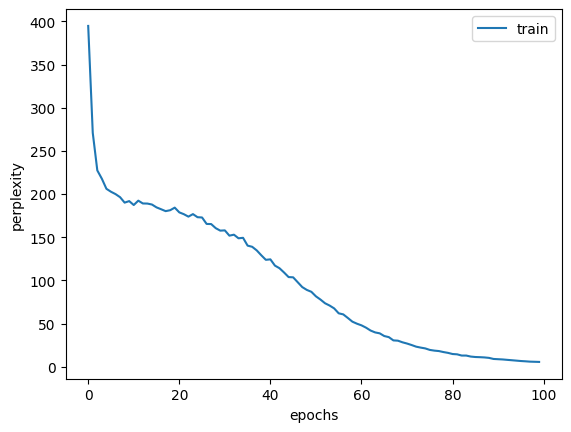

In [ ]:
# RNNLM의 학습 코드

import numpy as np
import matplotlib.pyplot as plt

# 하이퍼파라미터 설정
batch_size = 10
wordvec_size = 100
hidden_size = 100 # RNN의 은닉 상태 벡터의 원소 수
time_size = 5     # Truncated BPTT가 한 번에 펼치는 시간 크기
lr = 0.1
max_epoch = 100

# 학습 데이터 읽기(전체 중 1000개만)
corpus, word_to_id, id_to_word = load_data('train')
corpus_size = 1000
corpus = corpus[:corpus_size]
vocab_size = int(max(corpus) + 1)

xs = corpus[:-1]  # 입력
ts = corpus[1:]   # 출력(정답 레이블)
data_size = len(xs)
print('말뭉치 크기: %d, 어휘 수: %d' % (corpus_size, vocab_size))

# 학습 시 사용하는 변수
max_iters = data_size // (batch_size * time_size)
time_idx = 0
total_loss = 0
loss_count = 0
ppl_list = []

# 모델 생성 (SimpleRnnlm과 SGD 정의 필요)
model = SimpleRnnlm(vocab_size, wordvec_size, hidden_size)
optimizer = SGD(lr)

# 미니배치의 각 샘플의 읽기 시작 위치를 계산
jump = (corpus_size - 1) // batch_size
offsets = [i * jump for i in range(batch_size)]

# 학습 루프 시작
for epoch in range(max_epoch):
    for iter in range(max_iters):
        # 미니배치 취득
        batch_x = np.empty((batch_size, time_size), dtype='i')
        batch_t = np.empty((batch_size, time_size), dtype='i')
        for t in range(time_size):
            for i, offset in enumerate(offsets):
                batch_x[i, t] = xs[(offset + time_idx) % data_size]
                batch_t[i, t] = ts[(offset + time_idx) % data_size]
            time_idx += 1

        # 기울기를 구하여 매개변수 갱신
        loss = model.forward(batch_x, batch_t)
        model.backward()
        optimizer.update(model.params, model.grads)
        total_loss += loss  # placeholder
        loss_count += 1

    # 에폭마다 퍼플렉서티 평가
    ppl = np.exp(total_loss / loss_count)
    print('| 에폭 %d | 퍼플렉서티 %.2f'
          % (epoch+1, ppl))
    ppl_list.append(float(ppl))
    total_loss, loss_count = 0, 0

# 그래프 그리기
x = np.arange(len(ppl_list))
plt.plot(x, ppl_list, label='train')
plt.xlabel('epochs')
plt.ylabel('perplexity')
plt.legend()
plt.show()
